In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import random
import bisect
import re
import numpy as np


from collections import defaultdict
from collections import Counter
import random
import sys
import pickle

sys.path.insert(0,'../decryption')
sys.path.insert(0,'../encryption')
sys.path.insert(0,'../dictionaries')

import encrypt
import decrypt
import alphabet
import frequency

_ALPHABET = " abcdefghijklmnopqrstuvwxyz"

In [2]:
# simulation of problem
TEST_KEY_MAPPING = encrypt.generate_key_mapping()
TEST_CHAR_MAPPING = encrypt.char_key_mapping_from_key_mapping(TEST_KEY_MAPPING)

assert len(set(TEST_KEY_MAPPING)) == 27

TEST_PLAIN_TEXTS = []
with open('../dictionaries/official_dictionary_1_cleaned.txt','r') as f:
    content = f.readlines()
    for line in content:
        TEST_PLAIN_TEXTS.append(line.strip())

TEST_PLAIN_TEXTS[3] += ' '
TEST_PROBABILITY = 0.1
ciphers = [encrypt.encrypt(msg,TEST_KEY_MAPPING,TEST_PROBABILITY) for msg in TEST_PLAIN_TEXTS]

# pick a random cipher and start working with it. (We should not know the original plain text)
r = random.randint(0,len(ciphers)-1)
cipher_txt = ciphers[r]
test_plain_text = TEST_PLAIN_TEXTS[r]

In [3]:
with open('../dictionaries/official_dictionary_2_cleaned.txt') as file:
    lines = file.readlines()

DICTIONARY_LIST = []
DICTIONARY_SET = set()

for line in lines:
    line = re.sub('[^A-Za-z0-9]+', '', line.strip())
    DICTIONARY_LIST.append(line)
    DICTIONARY_SET.add(line)

In [4]:
def generate_test_one_cipher(p):
    num_key_mapping = encrypt.generate_key_mapping()
    char_key_mapping = encrypt.char_key_mapping_from_key_mapping(num_key_mapping)
    r = random.randint(0,len(ciphers)-1)
    cipher = encrypt.encrypt(TEST_PLAIN_TEXTS[r],num_key_mapping,p)
    return TEST_PLAIN_TEXTS[r],cipher,char_key_mapping,num_key_mapping

def generate_test_two_cipher(p):
    num_key_mapping = encrypt.generate_key_mapping()
    char_key_mapping = encrypt.char_key_mapping_from_key_mapping(num_key_mapping)
    plain_txt = " ".join(random.choices(DICTIONARY_LIST,k=200))[:500]
    cipher = encrypt.encrypt(plain_txt,num_key_mapping,p)
    return plain_txt,cipher,char_key_mapping,num_key_mapping
    

In [5]:
plain_txt,cipher,char_key_mapping,num_key_mapping = generate_test_two_cipher(0.2)

In [15]:
def build_rel_dist(text):
    rel_dist = defaultdict(list)
    rel_num = defaultdict(list)
    for j,c in enumerate(text):
        rel_dist[c].append((j/len(text)))
        rel_num[c].append(j)
    return rel_dist,rel_num

def get_diff(arr):
    diff = []
    for i in range(1,len(arr)):
        diff.append(round(arr[i]-arr[i-1],4))
    return diff

def get_char_diffs_data(char_rel_num,rel_num,l):
    left = []
    right = []
    avg_num_diff = []
    for i,num in enumerate(rel_num):
        char_closest_right = bisect.bisect_left(char_rel_num,num)
        char_closest_left = char_closest_right-1
        if char_closest_left == -1:
            lo = 0
        else:
            lo = char_rel_num[char_closest_left]
        if char_closest_right == len(char_rel_num):
            hi = l
        else:
            hi = char_rel_num[char_closest_right]
        left.append(num-lo)
        right.append(hi-num)
        avg_num_diff.append(right[-1] - left[-1])
        
    return left,right,avg_num_diff

def append(data,df):
    l = len(df)
    for k,v in data.items():
        df.loc[l,k] = v
        
def populate_dist_data(dist,prefix,data = dict()):
    data[prefix + '_mean'] = np.mean(dist)
    data[prefix + '_std'] = np.std(dist)
    
    max_moments = 3
    for i in range(2,max_moments+1):
        data[prefix+str(i)+'_num_moment'] = stats.moment(dist,i)
    
    return data


# features: space character frequency, last character frequency, difference from 500
# stats of space char freq diff, last char freq diff
# stats of char diffs data of last char and space char
# covariance of space char and last char data

def get_test_diff_data(c_rel_dist,c_rel_num,c_rel_num_diff,c_rel_dist_diff,space_data_c,last_char_mapping):
    data = dict()
    data['space_char_freq'] = len(c_rel_num[space_char])
    data['last_char_freq'] = len(c_rel_num[last_char_mapping])
    data['diff'] = len(cipher) - 500

    populate_dist_data(c_rel_num_diff[space_char],'space_diff',data)
    populate_dist_data(c_rel_num_diff[last_char_mapping],'last_char_diff',data)

    l = min(len(c_rel_num[space_char]),len(c_rel_num[last_char_mapping]))
    if l>1:
        data['last_space_num_first_cov'] = np.cov(c_rel_num[space_char][:l],c_rel_num[last_char_mapping][:l])[0][1]
    return data
    

In [16]:
# get distributions for cipher
c_rel_dist,c_rel_num = build_rel_dist(cipher)
c_rel_num_diff = defaultdict(list,{k:get_diff(v) for k,v in c_rel_num.items()})
c_rel_dist_diff = defaultdict(list,{k:get_diff(v) for k,v in c_rel_dist.items()})

space_char = decrypt.get_space_key_value(cipher)
space_data_c = defaultdict(list,{c:get_char_diffs_data(c_rel_num[space_char],c_rel_num[c],len(cipher)) for c in _ALPHABET})

last_char_mapping = cipher[-1]
last_char_data_c = defaultdict(list,{c:get_char_diffs_data(c_rel_num[last_char_mapping],c_rel_num[c],len(cipher)) for c in _ALPHABET})
    

In [29]:
cols = [
    'space_char_freq',
     'last_char_freq',
     'diff',
     'space_diff_mean',
     'space_diff_std',
     'space_diff2_num_moment',
     'space_diff3_num_moment',
     'last_char_diff_mean',
     'last_char_diff_std',
     'last_char_diff2_num_moment',
     'last_char_diff3_num_moment',
     'last_space_num_first_cov',
        'result'
]


In [30]:
def iter_tests(p,num):
    for _ in range(num):
        plain_txt,cipher,char_key_mapping,num_key_mapping = generate_test_one_cipher(p)
        yield plain_txt,cipher,char_key_mapping,num_key_mapping,True
        
        plain_txt,cipher,char_key_mapping,num_key_mapping = generate_test_two_cipher(p)
        yield plain_txt,cipher,char_key_mapping,num_key_mapping,False

def iter_prob_tests(pmin,pmax,step,num):
    for prob in range(pmin,pmax+1,step):
        print('generating for prob',prob)
        for plain_txt,cipher,char_key_mapping,num_key_mapping,result in iter_tests(prob/100,num):
            yield plain_txt,cipher,char_key_mapping,num_key_mapping,result

In [83]:
df = pd.DataFrame(columns = cols)
for plain_txt,cipher,char_key_mapping,num_key_mapping,result in iter_prob_tests(1,70,1,300):
    # get distributions for cipher
    c_rel_dist,c_rel_num = build_rel_dist(cipher)
    c_rel_num_diff = defaultdict(list,{k:get_diff(v) for k,v in c_rel_num.items()})
    c_rel_dist_diff = defaultdict(list,{k:get_diff(v) for k,v in c_rel_dist.items()})

    space_char = decrypt.get_space_key_value(cipher)
    space_data_c = defaultdict(list,{c:get_char_diffs_data(c_rel_num[space_char],c_rel_num[c],len(cipher)) for c in _ALPHABET})

    last_char_mapping = cipher[-1]
    last_char_data_c = defaultdict(list,{c:get_char_diffs_data(c_rel_num[last_char_mapping],c_rel_num[c],len(cipher)) for c in _ALPHABET})
    
    data = get_test_diff_data(c_rel_dist,c_rel_num,c_rel_num_diff,c_rel_dist_diff,space_data_c,last_char_mapping)
    data['result'] = result
    
    append(data,df)
    
    

generating for prob 1


/Users/adityachawla/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/adityachawla/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/adityachawla/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/adityachawla/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/adityachawla/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


generating for prob 2
generating for prob 3
generating for prob 4
generating for prob 5
generating for prob 6
generating for prob 7
generating for prob 8
generating for prob 9
generating for prob 10
generating for prob 11
generating for prob 12
generating for prob 13
generating for prob 14
generating for prob 15
generating for prob 16
generating for prob 17
generating for prob 18
generating for prob 19
generating for prob 20
generating for prob 21
generating for prob 22
generating for prob 23
generating for prob 24
generating for prob 25
generating for prob 26
generating for prob 27
generating for prob 28
generating for prob 29
generating for prob 30
generating for prob 31
generating for prob 32
generating for prob 33
generating for prob 34
generating for prob 35
generating for prob 36
generating for prob 37
generating for prob 38
generating for prob 39
generating for prob 40
generating for prob 41
generating for prob 42
generating for prob 43
generating for prob 44
generating for prob

In [84]:
df = df.fillna(0)

In [85]:
# build a model
import torch
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [86]:
output_idx = list(df.columns).index('result')
input_cols = list(df.columns)
input_cols.remove('result')
X = df.loc[:,input_cols].values
y = df.iloc[:,output_idx].values.reshape(-1,1).astype(np.float64)


X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.20)
num_feat = X_train_raw.shape[1]

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = torch.from_numpy(scaler.transform(X_train_raw)).float()
X_test = torch.from_numpy(scaler.transform(X_test_raw)).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [87]:
train_dataset = TensorDataset(X_train,y_train) # create your datset
train_dataloader = DataLoader(train_dataset,batch_size=16,shuffle=True) # create your dataloader

test_dataset = TensorDataset(X_test,y_test) # create your datset
test_dataloader = DataLoader(test_dataset,batch_size=16,shuffle=True) # create your dataloader

In [88]:
num_feat = len(X_train[0])

In [89]:


num_feat = len(X_train[0])
class NeuralNet(torch.nn.Module): 
    def __init__(self):
        super(NeuralNet,self).__init__()

        self.relu = torch.nn.ReLU()
        
        self.lin1 = torch.nn.Linear(num_feat, 16)
        
        self.lin2 =torch.nn.Linear(16, 64)
        
        self.lin3 =torch.nn.Linear(64, 16)
        
        self.lin4 =torch.nn.Linear(16, 1)
        
        self.out = torch.nn.Sigmoid()
        
        self.float()
        
    def forward(self, x):
        x = self.lin1(x)
        x = self.relu(x)
        
        x = self.lin2(x)
        x = self.relu(x)
        
        x = self.lin3(x)
        x = self.relu(x)
        
        x = self.lin4(x)
        x = self.out(x)
        
        return x

net = NeuralNet()
loss = torch.nn.BCELoss() # pass output, target
optimizer = torch.optim.Adam(net.parameters(), lr=0.002)


In [90]:
train_loss_history = []
test_loss_history = []

In [91]:
epochs = 200
for epoch in range(epochs):
    train_loss = 0.0
    test_loss = 0.0
    for i, data in enumerate(train_dataloader):
        net.train()
        a_inp, a_out = data
        optimizer.zero_grad()
        predicted_output = net(a_inp)
        fit = loss(predicted_output,a_out) # loss(p_out,a_out)
        fit.backward()
        optimizer.step()
        train_loss += fit.item()

    for i, data in enumerate(test_dataloader):
        net.eval()
        with torch.no_grad():
            a_inp, a_out = data
            predicted_output = net(a_inp)
            fit = loss(predicted_output,a_out)
            test_loss += fit.item()
            predicted = torch.max(predicted_output.data, 1)

    train_loss = train_loss/len(train_dataloader)
    test_loss = test_loss/len(test_dataloader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    print('Epoch %s, Train loss %s, Test loss %s'%(epoch, train_loss, test_loss))

Epoch 0, Train loss 0.41471142162524516, Test loss 0.3668972308153198
Epoch 1, Train loss 0.3569944438267322, Test loss 0.3382492370335829
Epoch 2, Train loss 0.33897732229282457, Test loss 0.3310662922546977
Epoch 3, Train loss 0.32869403859156937, Test loss 0.321252604779743
Epoch 4, Train loss 0.3219458256786068, Test loss 0.3121648563231741
Epoch 5, Train loss 0.3176465058078369, Test loss 0.312115569185643
Epoch 6, Train loss 0.3146590397471473, Test loss 0.31689377710932776
Epoch 7, Train loss 0.30908499887124413, Test loss 0.3088335668473017
Epoch 8, Train loss 0.3070461794884787, Test loss 0.3203297590996538
Epoch 9, Train loss 0.3037032080051445, Test loss 0.3260805105595362
Epoch 10, Train loss 0.30131242226809263, Test loss 0.302986280861355
Epoch 11, Train loss 0.2986062331355753, Test loss 0.299646894427992
Epoch 12, Train loss 0.2982717684301592, Test loss 0.30397936100051515
Epoch 13, Train loss 0.29577735162916635, Test loss 0.3314714535786992
Epoch 14, Train loss 0.294

Epoch 116, Train loss 0.2454982174383033, Test loss 0.2785157692148572
Epoch 117, Train loss 0.24579633737249035, Test loss 0.2841966192069508
Epoch 118, Train loss 0.24545038753588286, Test loss 0.2827223904572782
Epoch 119, Train loss 0.24455113579031257, Test loss 0.28078997287721863
Epoch 120, Train loss 0.24491264789143488, Test loss 0.27995482773475705
Epoch 121, Train loss 0.2443547195967819, Test loss 0.2751993832453376
Epoch 122, Train loss 0.2429988899507693, Test loss 0.2804988120496273
Epoch 123, Train loss 0.24408242132514715, Test loss 0.28165381992856664
Epoch 124, Train loss 0.24440209479869476, Test loss 0.28163798681327273
Epoch 125, Train loss 0.24267167867427425, Test loss 0.28155613999636403
Epoch 126, Train loss 0.24401357473184665, Test loss 0.2711680967963877
Epoch 127, Train loss 0.24269836219825916, Test loss 0.2853784396712269
Epoch 128, Train loss 0.24303147324050467, Test loss 0.2884739173833458
Epoch 129, Train loss 0.2422151545067096, Test loss 0.28235876

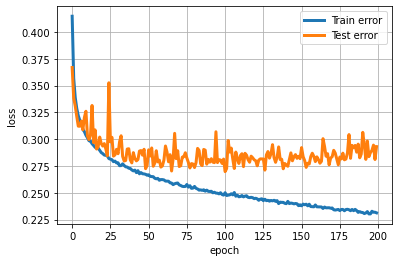

In [92]:
plt.plot(range(len(train_loss_history)),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(len(test_loss_history)),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

In [93]:
correct = 0
total = 0

net.eval()
for i, data in enumerate(test_dataloader):
    with torch.no_grad():
        a_inp, a_out = data
        predicted_output = net(a_inp)
        p_arr = predicted_output.detach().numpy()
        a_out = a_out.detach().numpy()
        for i in range(len(a_out)):
            if abs(p_arr[i] - a_out[i])<0.5:
                correct += 1
            total += 1

print('accuracy is',correct/total)

accuracy is 0.87


In [127]:
import pickle
cols_one = input_cols
with open('columns_diff_test.pkl', 'wb') as handle:
    pickle.dump(cols_one, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('scaler_diff_test.pkl', 'wb') as handle:
    pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
torch.save(net.state_dict(),'model_diff_test.state')